In [130]:
from IPython.display import SVG
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import re
from sknetwork.ranking import PageRank
from sknetwork.visualization import svg_graph

In [2]:
names=['en', 'hu', 'la', 'pl', 'id', 'uro', 'pos', 'defi', 'comment']
fl = pd.read_csv('4lang', sep='\t', names=names)

# Computing the definition graph

In [3]:
fl = fl[~fl.defi.isna()]

In [4]:
fl.en = fl.en.str.lower()

In [5]:
fl.defi = fl.defi.str.lower()

In [6]:
fl['ambig'] = fl.en.duplicated(keep=False)

In [7]:
unambig_set = set(fl.loc[~fl.ambig,'en'])

In [8]:
def unambig_hwd(record):
    return f'{record.en}/{record.id}' if record.ambig else record.en

In [9]:
fl['unambig_hwd'] = fl.apply(unambig_hwd, axis=1)

In [10]:
def drop_needless_disambig(term):
    if '/' in term:
        word, number = term.split('/')
        if word in unambig_set:
            return word
    return term

In [11]:
concept_chars = '=@a-zA-Z_/0-9-'
parens_and_stuff = "[]<>,()'"

def get_def_graph_outlist(record):
    hwd = f'{record.en}/{record.id}' if record.ambig else record.en
    return hwd, [drop_needless_disambig(concept) 
                 for concept in re.findall(f'[{concept_chars}]+', str(record.defi))]

In [12]:
def_graph = nx.DiGraph(dict(fl.apply(get_def_graph_outlist, axis=1).values))

# Exploration

In [13]:
#SVG(svg_graph(nx.adjacency_matrix(def_graph)))

In [14]:
pd.Series(dict(def_graph.in_degree())).sort_values(ascending=False)

has           555
=agt          357
=pat          323
at            308
cause         308
             ... 
proclaim        0
procession      0
drip            0
proceed         0
-able           0
Length: 3185, dtype: int64

In [15]:
pd.Series(dict(def_graph.out_degree())).sort_values(ascending=False)

park         16
lens         16
golf         15
fox          14
honey        14
             ..
@hamburg      0
@hanukkah     0
@hawaii       0
@himalaya     0
=for          0
Length: 3185, dtype: int64

In [16]:
fl.shape

(2965, 11)

In [17]:
def_graph.number_of_nodes()

3185

In [18]:
def_graph.number_of_edges()

11023

# Primitives

In [19]:
%pprint
print(sorted(set(concept 
                 for concept in set(def_graph.nodes) - set(fl.unambig_hwd)  if not re.match('^[=@]', concept))))
%pprint

Pretty printing has been turned OFF
['all', 'also', 'be', 'before', 'celebrate', 'characteristic', 'enthusiastic', 'er', 'for', 'for/2782', 'from', 'has', 'identity', 'inherent', 'is_a', 'lack', 'next_to', 'not', 'other', 'palm', 'part_of', 'passionate', 'target', 'tired', 'want']
Pretty printing has been turned ON


# Strongly connected components

In [20]:
def get_components_with_size():
    for component in nx.strongly_connected_components(def_graph):
        yield ', '.join(sorted(component)), len(component)

In [21]:
components = pd.Series(dict(get_components_with_size()))

In [54]:
components.sort_values(ascending=False, inplace=True)

In [22]:
len(components)

2478

In [65]:
components[0]

623

In [64]:
print(components[components>2][1:].to_latex())

\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
april, august, december, february, january, jul... &  12 \\
friday, monday, saturday, sunday, thursday, tue... &   7 \\
bed, chair, cupboard, furniture, table             &   5 \\
cereal, flour, grain, wheat                        &   4 \\
draw/2707, pen, pencil, write                      &   4 \\
king, monarch, queen, royal                        &   4 \\
autumn, spring/2318, summer, winter                &   4 \\
buttocks, seat, sit                                &   3 \\
camera, lens, photograph                           &   3 \\
calm, disturb, upset                               &   3 \\
answer, question, reply                            &   3 \\
bake, bread, cake                                  &   3 \\
female, male, sex                                  &   3 \\
justice, right/1191, wrong                         &   3 \\
actor, stage/2220, theatre                         &   3 \\
many, much, quantity                              

/tmp/ipykernel_27186/2481590247.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(components[components>2][1:].to_latex())


In [25]:
components[components==3]

many, much, quantity          3
female, male, sex             3
husband, marriage, wife       3
poem, poet, poetry            3
justice, right/1191, wrong    3
camera, lens, photograph      3
actor, stage/2220, theatre    3
answer, question, reply       3
bake, bread, cake             3
buttocks, seat, sit           3
calm, disturb, upset          3
cutlery, fork, spoon          3
dtype: int64

In [26]:
components[components==2].to_latex

cause, reason             2
exist, real               2
hill, mountain            2
book, page                2
electricity, wire         2
programme, television     2
acid, sour                2
bottle, glass             2
now, this                 2
attention, interesting    2
level, scale              2
balance/1607, weigh       2
dirt, dust                2
door, entrance            2
bell, ring/2735           2
brush, paint              2
thick/2134, thin/1038     2
problem, solve            2
hang, swing               2
dig, spade                2
elephant, trunk/1910      2
guest, host/2605          2
horse, ride               2
rat, rodent               2
news, newspaper           2
president, republic       2
school, student           2
soap, wash                2
dtype: int64

In [66]:
components[components==1].inex

<bound method NDFrame.to_latex of linoleum     1
lime/1609    1
lip          1
lightning    1
lime/2773    1
            ..
store        1
shelf        1
pity         1
beg          1
vine         1
Length: 2430, dtype: int64>

## Edges between the huge component and the medium ones

In [27]:
'month' in components.index[0]

False

In [28]:
%pprint
print(sorted(list(nx.neighbors(def_graph, 'month'))))
%pprint

Pretty printing has been turned OFF
['part_of', 'time', 'twelve', 'unit', 'year']
Pretty printing has been turned ON


In [29]:
%pprint
print(sorted(list(nx.neighbors(def_graph.reverse(), 'month'))))
%pprint

Pretty printing has been turned OFF
['12-month', 'april', 'august', 'date', 'day', 'december', 'february', 'january', 'july', 'june', 'march/1563', 'may/1560', 'november', 'october', 'salary', 'september', 'year']
Pretty printing has been turned ON


## Singletons

In [30]:
in_degree_ser = pd.Series(dict(def_graph.in_degree()))

In [31]:
out_degree_ser = pd.Series(dict(def_graph.out_degree()))

In [32]:
components[components==1]

=poss         1
=agt          1
before        1
=pat          1
er            1
             ..
billiards     1
chess         1
confidence    1
dr            1
vine          1
Length: 2430, dtype: int64

In [33]:
list(nx.neighbors(def_graph, 'linoleum'))

['material', 'cover', 'floor', 'strong']

In [34]:
list(nx.neighbors(def_graph.reverse(), 'linoleum'))

[]

In [35]:
components['ability']

1

In [36]:
list(nx.neighbors(def_graph, 'ability'))

['can/1246']

In [37]:
list(nx.neighbors(def_graph.reverse(), 'ability'))

['modest']

In [38]:
components['modest']

1

In [39]:
list(nx.neighbors(def_graph.reverse(), 'modest'))

['humble']

In [141]:
ser = pd.Series(dict(zip(def_graph.nodes, scores)))

# PageRank

In [180]:
def get_pagerank_df():
    columns = {}
    for damping_factor in [.85, .9, .95]:
        scores = PageRank(damping_factor=damping_factor).fit_predict(nx.adjacency_matrix(def_graph))
        columns[f'pagerank_{damping_factor}'] = dict(zip(def_graph.nodes, scores))
    df = pd.DataFrame(columns)
    df['primitive'] = [w not in fl.index for w in df.index]
    return df

In [239]:
pageRank_df = get_pagerank_df()

/tmp/ipykernel_27186/1930533376.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  scores = PageRank(damping_factor=damping_factor).fit_predict(nx.adjacency_matrix(def_graph))


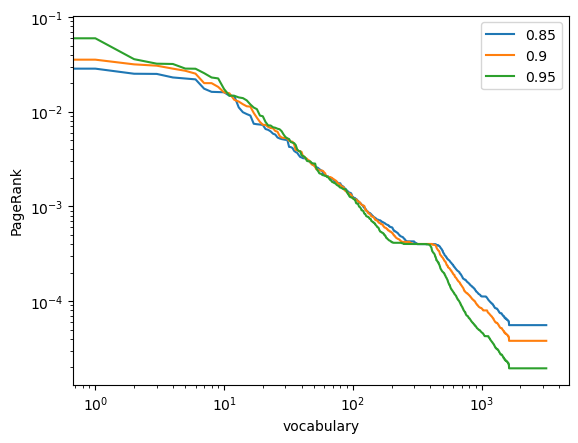

In [240]:
factors = [.85, .9, .95]
for damping_factor in factors:
    plt.plot(pageRank_df[f'pagerank_{damping_factor}'].sort_values(ascending=False).values)
plt.xscale('log')
plt.yscale('log')
plt.legend(factors)
plt.xlabel('vocabulary')
plt.ylabel('PageRank')
plt.savefig(f'/home/makrai/repo/paper/thesis/makrai_phd/img/pageRank-sorted-separately.png')

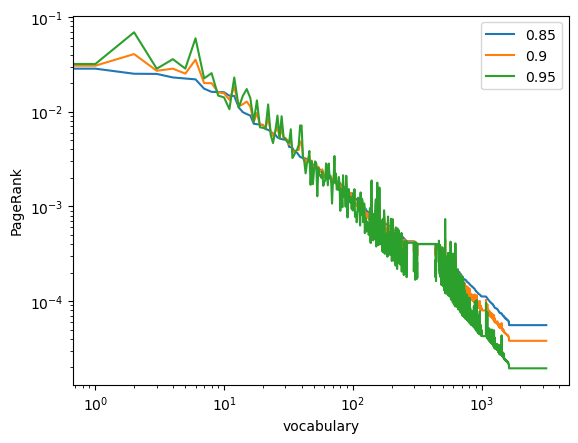

In [241]:
pageRank_df.sort_values(f'pagerank_0.85', ascending=False, inplace=True)
plt.plot(pageRank_df.drop(columns=['primitive']))
plt.xscale('log')
plt.yscale('log')
plt.legend(factors)
plt.xlabel('vocabulary')
plt.ylabel('PageRank')
plt.savefig(f'/home/makrai/repo/paper/thesis/makrai_phd/img/pageRank-aligned.png')

In [242]:
pageRank_df.reset_index(inplace=True)

In [245]:
def scatter_records(df, indic, damping_factor=.85):
    values = df.loc[indic, f'pagerank_{damping_factor}']
    plt.scatter(df[indic].index, values, s=1)

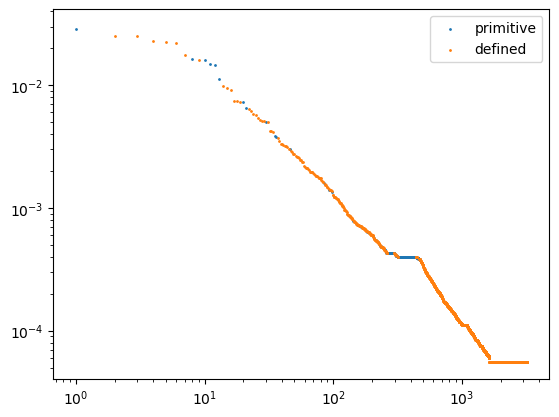

In [251]:
#factors = [.85, .9, .95]
#legend = []
damping_factor=0.85
scatter_records(pageRank_df, pageRank_df.primitive, damping_factor=damping_factor)
scatter_records(pageRank_df, ~pageRank_df.primitive, damping_factor=damping_factor)
plt.xscale('log')
plt.yscale('log')
plt.legend(['primitive', 'defined'])
plt.savefig(f'/home/makrai/repo/paper/thesis/makrai_phd/img/pageRank-85-primitive.png')

In [ ]:
with open('../paper/thesis/makrai_phd/img/pageRank-of-top-concepts.tex', mode='w') as file:
    file.write(

In [255]:
pageRank_df.head(50)

,index,pagerank_0.85,pagerank_0.9,pagerank_0.95,primitive
0,has,0.030417,0.031716,0.032239,True
1,=pat,0.028574,0.030711,0.032011,True
2,exist,0.025244,0.040721,0.069136,False
3,at,0.025138,0.027126,0.028517,False
4,reason,0.023064,0.028577,0.035985,False
5,cause,0.022473,0.025304,0.028615,False
6,real,0.022016,0.035551,0.059786,False
7,place/1026,0.017554,0.020090,0.022533,False
8,er,0.016251,0.020077,0.025601,True
9,in,0.016165,0.016037,0.014831,False


In [254]:
.style.to_latex())

# The top

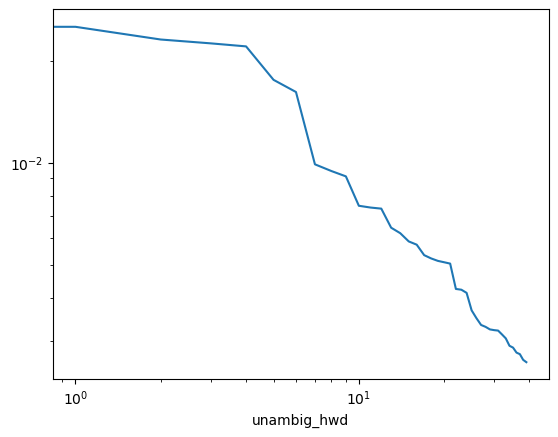

In [45]:
fl.iloc[:40].pagerank.plot()
plt.xscale('log')
plt.yscale('log')

In [109]:
fl.uro.fillna('', inplace=True)

In [117]:
fl.columns

Index(['en', 'hu', 'la', 'pl', 'id', 'uro', 'pos', 'defi', 'comment', 'ambig',
       'pagerank_0.85', 'pagerank_0.9', 'pagerank_0.95'],
      dtype='object')

In [119]:
columns = ['en', 'pagerank_0.85', 'pagerank_0.9', 'pagerank_0.95', 'hu', 'la', 'pl', 'uro', 'pos', 'defi']
with open('../paper/thesis/makrai_phd/img/4lang-by-PageRank.tex', mode='w') as file:
    file.write(fl[columns].head(30).style.to_latex())

## _Exist_ and _real_

### Out-neighbors

In [47]:
list(def_graph.neighbors('exist'))

['real']

In [48]:
list(def_graph.neighbors('real'))

['exist']

### In-neighbors

In [49]:
%pprint
print(sorted(list(def_graph.reverse().neighbors('exist'))))
%pprint

Pretty printing has been turned OFF
['actual', 'destroy', 'establish', 'fact', 'live', 'make', 'new', 'origin', 'real', 'thing']
Pretty printing has been turned ON


In [50]:
%pprint
print(sorted(list(def_graph.reverse().neighbors('real'))))
%pprint

Pretty printing has been turned OFF
['article', 'artificial', 'believe', 'dream', 'exist', 'expect', 'fiction', 'imaginary', 'practice', 'prove', 'romantic', 'sincere', 'succeed/2718', 'success']
Pretty printing has been turned ON


# The tail

In [51]:
fl[fl.pagerank<.000057]

,en,hu,la,pl,id,uro,pos,defi,comment,ambig,pagerank
unambig_hwd,,,,,,,,,,,
stretch,stretch,nyu1jt,porrigo,rozcia1gac1,1823,NaN,N,"cause[=pat[long,extend]]",NaN,False,0.000056
when,when,mikor,quando,kiedy,1689,u,D,at/2744 what(time),NaN,False,0.000056
presence,presence,jelenle1t,praesentia,obecnos1c1,1185,NaN,N,=poss at/2744 place/1026,NaN,False,0.000056
sorry,sorry,bu1s,tristis,smutny,342,u,A,feel pity,NaN,False,0.000056
something,something,valami,aliquid,cos1,2579,NaN,N,thing,NaN,False,0.000056
...,...,...,...,...,...,...,...,...,...,...,...
friend,friend,bara1t,amicus,przyjaciel,228,u,N,"person, =poss know, =poss like/3382, =poss trust",NaN,False,0.000056
fresh,fresh,friss,viridis,s1wiez1y,863,NaN,N,"new, replace",NaN,False,0.000056
french-canadian,french-canadian,francia-kanadai,#,#,3299,NaN,A,"member [nation,@canada], has parent, parent me...",NaN,False,0.000056


In [52]:
fl.groupby([in_degree_ser==0,fl.pagerank<5.578344e-05]).size()

       pagerank
False  False       1414
True   True        1551
dtype: int64